Make an active learning set that is designed to be hard for active learning algorithms to deal with.

In [60]:
import os
from functools import partial
import numpy as np
from sklearn.datasets import make_classification
from sklearn import svm
from modAL import batch
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from joblib import delayed

from ipynb.fs.defs.Datasets import generateData_twoPills_2D, generateData_twoPills_noNoise_2D, plot_dataset_2D

import libactive
import libadversarial
from libactive import MyActiveLearner, active_split
from libadversarial import deepfool, fgm, random_batch, uncertainty, uncertainty_id
from libutil import ProgressParallel
from libplot import plot_classification

In [73]:
X1 = np.column_stack((
    np.random.normal(
        -0.75,
        0.25,
        300
    ),
    np.random.normal(
        1,
        0.25,
        300
    )
))

y1 = np.full(300, 0)

X2 = np.column_stack((
    np.random.normal(
        0.75,
        0.25,
        300
    ),
    np.random.normal(
        1,
        0.25,
        300
    )
))

y2 = np.full(300, 1)

X3 = np.column_stack((
    np.random.normal(
        -4,
        0.25,
        300
    ),
    np.random.normal(
        3,
        0.25,
        300
    )
))

y3 = np.full(300, 1)

X = np.concatenate((X1, X2, X3), axis=0)
y = np.concatenate((y1, y2, y3), axis=0)

print(X.shape, y.shape)

(900, 2) (900,)


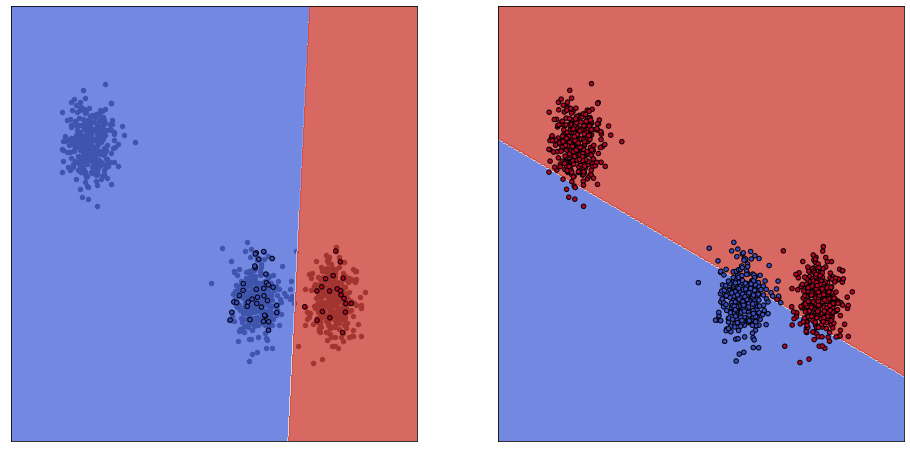

In [78]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,8))
clf = svm.SVC(kernel='linear')
clf.fit(X, y)
plot_classification(ax2, clf, X, y, X)
clf = svm.SVC(kernel='linear')
X_b, y_b = X_labelled[np.where(X_labelled[:,1] < 2)], y_labelled[np.where(X_labelled[:,1] < 2)]
clf.fit(X_b, y_b)
ax1.scatter(X[:,0], X[:,1], c='black', s=20)
plot_classification(ax1, clf, X_b, y_b, X)

In [102]:
query_methods = {
    "random": random_batch,
    "uncertainty": batch.uncertainty_batch_sampling,
    "uncertainty_id": uncertainty_id,
    "fgm": fgm,
    "fgm minimal": partial(fgm, minimal=True),
    # deepfool is **slow**
    "deepfool": deepfool
}

In [94]:
from importlib import reload
reload(libactive); from libactive import MyActiveLearner

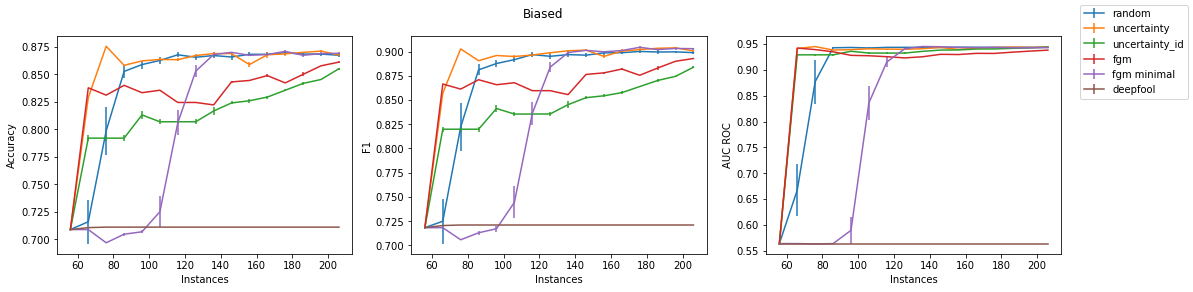

In [104]:
# Annoying hack so that the progressbars disapear as they're supposed to
from IPython.core.display import HTML, display
display(HTML("""
<style>
.p-Widget.jp-OutputPrompt.jp-OutputArea-prompt:empty {
  padding: 0;
  border: 0;
}
.p-Widget.jp-RenderedText.jp-OutputArea-output pre:empty {
  display: none;
}
</style>
"""))

X_labelled, X_unlabelled, y_labelled, y_oracle, X_test, y_test = active_split(X, y, labeled_size=0.1)

for bias in tqdm([True], desc="Bias", leave=False):
    if bias:
        idx = np.where(X_labelled[:,1] < 2)
        X_biased = X_labelled[idx]
        y_biased = y_labelled[idx]
    else:
        X_biased, y_biased = X_labelled, y_labelled

    fig, axes = plt.subplots(1, 3, figsize=(18,4))
    
    for name, method in tqdm(query_methods.items(), desc=f"Method", leave=False):
        metrics = ProgressParallel(n_jobs=4, total=10, desc=f"Run", leave=False)(
            delayed(
                lambda X_labelled,X_unlabelled,Y_labelled,Y_oracle,X_test,Y_test, method: MyActiveLearner().active_learn2(
                    X_labelled,X_unlabelled,Y_labelled,Y_oracle,X_test,Y_test, 
                    query_strategy=method, 
                    stop_function=lambda learner: learner.X_training.shape[0] > 200
                )
            )(X_biased,X_unlabelled,y_biased,y_oracle,X_test,y_test, partial(method, n_instances=10))
            for _ in range(10)
        )
        metrics, stderr = metrics[0].average(metrics[1:])
        #metrics.to_csv(f"Experiments/experiment_angle_{angle}_method_{method.__name__}.csv")
        #stderr.to_csv(f"Experiments/experiment_angle_{angle}_method_{method.__name__}_stderr.csv")
        
        for i, ax in enumerate(axes.flatten()):
            ax.errorbar(metrics['x'], metrics.iloc[:,1+i], yerr=stderr.iloc[:,1+i], label=f"{name}" if i == 0 else "")
            ax.set_xlabel("Instances"); ax.set_ylabel(["Accuracy", "F1", "AUC ROC"][i]); plt.suptitle(f"Biased" if bias else "Unbiased")
            #if i != 2:
                #ax.set_ylim(0.84, 0.9)
                
    fig.legend()

Dealing with pits:

* Don't, and hope you don't fall in or that you randomly climb out
* Information density (never fall in, sacrifices best-case active learning)
* 2-armed bandit? might be relevant here... where did I see it before?
  Active learning by learning meta-algorithm
  Instead we could use this approach to tradeoff exploring new data areas with margin improvement?
* Recognise when you've fallen in:
    * If decision boundary doesn't move, or moves less than expected?
      I don't think that works...

In [88]:
reload(libadversarial); from libadversarial import fgm

In [99]:
MyActiveLearner(animate=True).active_learn2(X_biased,X_unlabelled,y_biased,Y_oracle,X_test,Y_test, partial(fgm, n_instances=10, minimal=True));

In [98]:
from importlib import reload
reload(libactive); from libactive import MyActiveLearner
MyActiveLearner(animate=True).active_learn2(X_biased,X_unlabelled,y_biased,Y_oracle,X_test,Y_test, partial(fgm, n_instances=10, minimal=False));